# **Segmentation of Sclera**

**Special Requirements**

In [ ]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
#For live loss function updates
!pip install livelossplot
!pip install h5py==2.10.0

     |████████████████████████████████| 50 kB 3.9 MB/s 
     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 448 kB 43.7 MB/s 
     |████████████████████████████████| 3.8 MB 24.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=ac1ef8ecad6d90d1bf7e76af39ee42d1104d0d31d5d619cbeb822c6f458520aa
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

**Mounting the Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Required Libraries**

In [ ]:
%matplotlib inline

In [ ]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted

In [ ]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


**Storing & Creating Training sets from images from mounted drive**

In [ ]:
#print(os.listdir("membrane/train"))

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128
OGX = 3000
OGY = 1700

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/ss_train/image"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*png"))) :
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR )   #cv2.IMREAD_COLOR    
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
   
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing  

   
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/ss_train/mask"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        #print(mask_path)
        mask = cv2.imread(mask_path, 0)   #,0    
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR) #
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)


In [ ]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)


**Define Model**

In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())


85524480/85521592 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
___________________________

**Model Fitting (One Time)**

In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
from livelossplot import PlotLossesKeras
#Include this as callback., but slows the training (callbacks=[PlotLossesKeras()],)
model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=200,
   verbose=1,
   validation_data=(x_val, y_val),
)

#accuracy = model.evaluate(x_val, y_val)


Train on 68 samples, validate on 18 samples
Epoch 1/200
68/68 [==============================] - 16s 231ms/step - loss: -3.5990 - iou_score: 1.5923 - val_loss: -498.2863 - val_iou_score: 21.9596
Epoch 2/200
68/68 [==============================] - 1s 20ms/step - loss: -53.0173 - iou_score: 5.5981 - val_loss: -275.0855 - val_iou_score: 21.1020
Epoch 3/200
68/68 [==============================] - 1s 20ms/step - loss: -90.6574 - iou_score: 9.4268 - val_loss: -1013.8630 - val_iou_score: 21.8844
Epoch 4/200
68/68 [==============================] - 1s 20ms/step - loss: -124.8576 - iou_score: 12.7651 - val_loss: -1216.0663 - val_iou_score: 21.7423
Epoch 5/200
68/68 [==============================] - 1s 20ms/step - loss: -153.6363 - iou_score: 23.5687 - val_loss: -1158.2037 - val_iou_score: 21.7519
Epoch 6/200
68/68 [==============================] - 1s 20ms/step - loss: -176.0636 - iou_score: 31.2571 - val_loss: -2198.7896 - val_iou_score: 21.6632
Epoch 7/200
68/68 [==========================

**Saving the Model**

In [ ]:
model.save('/content/drive/MyDrive/ss_train/Sclera_140.h5')

**Testing Area**

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/ss_train/Sclera_140.h5', compile=False)

**Upload & Read Image**

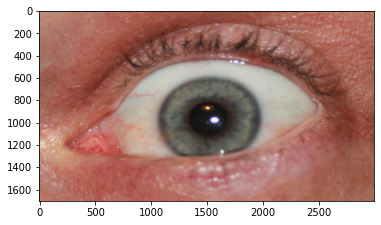

In [ ]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/13R_s_5.jpg', cv2.IMREAD_COLOR) 
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_image = test_img 
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
     

test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

test_image = cv2.resize(test_image, (OGX, OGY))
plt.imshow(test_image)



**Segmentate Mask**

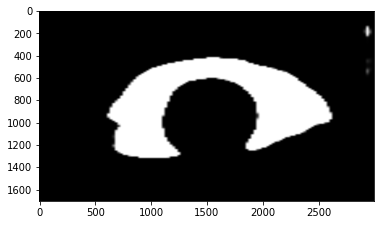

In [ ]:
#View and Save segmented image
prediction_image = prediction.reshape((SIZE_X,SIZE_Y))

prediction_image = cv2.resize(prediction_image, (OGX, OGY))
plt.imshow(prediction_image, cmap='gray')
plt.imsave('/content/drive/MyDrive/testing/segmented.jpg', prediction_image, cmap='gray')


**Test Image + Segmentate Mask**

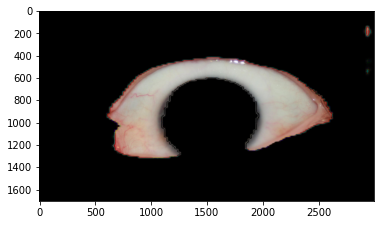

In [ ]:
imgg = cv2.imread('/content/drive/MyDrive/testing/segmented.jpg')  
  
#imgg2 = cv2.resize(imgg2, (SIZE_Y, SIZE_X))   
imgg = cv2.resize(imgg, (OGX, OGY))
imgg =  cv2.cvtColor(imgg, cv2.COLOR_RGB2BGR) 
annd = cv2.bitwise_and(imgg, test_image)
plt.imshow(annd, cmap='gray')

**Filter for veins**

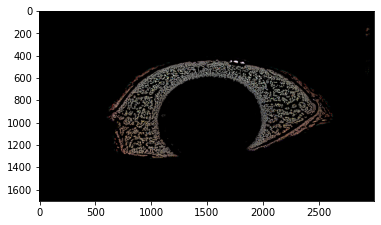

In [ ]:

from skimage.filters import frangi, hessian



image = test_image
#image = cv2.imread('/content/53L_s_1.jpg', cv2.IMREAD_COLOR)
seg=(hessian(image) )

plt.imsave('/content/drive/MyDrive/eye/final2.jpg', seg, cmap='gray')

seg2= cv2.imread('/content/drive/MyDrive/eye/final2.jpg')

annd2 = cv2.bitwise_and(seg2, annd)
plt.imshow(annd2, cmap='gray')